In [1]:
import os

os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"
os.environ['MPLCONFIGDIR'] = '/cs/student/projects1/aibh/2024/rmaheswa/cache/matplotlib'


In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# from datasets import load_from_disk
# import torch.nn as nn, torch.nn.functional as F
# import torch, json
# from transformers import BertTokenizer, BertModel
# from utils import BertModel as MedBertModel
# from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification
# from tqdm import tqdm
# from torch.utils.data import DataLoader

# class Pooler(nn.Module):
#     def __init__(self, config, pretrained_proj, proj_dim):
#         super().__init__()
#         self.proj = nn.Linear(config.hidden_size, proj_dim)
#         self.proj.load_state_dict(torch.load(pretrained_proj))
#     def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
#         pooled_output = hidden_states[:, 0]
#         pooled_output = F.normalize(self.proj(pooled_output), dim=-1)
#         return pooled_output
    
# model = BertModel.from_pretrained('LangCell/ckpt/cell_bert')
# model.pooler = Pooler(model.config, pretrained_proj='LangCell/ckpt/cell_proj.bin', proj_dim=256)
# proj = model.pooler.proj
# # model = model.module
# model = model.to("cuda")

# text_pretrained_model = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
# tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)
# tokenizer.add_special_tokens({'bos_token':'[DEC]'})
# tokenizer.add_special_tokens({'additional_special_tokens':['[ENC]']})       
# tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]  
# text_encoder = MedBertModel.from_pretrained('LangCell/ckpt/text_bert', add_pooling_layer=True)
# text_encoder.pooler = Pooler(text_encoder.config, pretrained_proj='LangCell/ckpt/text_proj.bin', proj_dim=256)
# text_encoder = text_encoder.to("cuda")

# ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)
# ctm_head.load_state_dict(torch.load('LangCell/ckpt/ctm_head.bin'))
# ctm_head = ctm_head.to("cuda")

In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from datasets import load_from_disk
import torch.nn as nn, torch.nn.functional as F
import torch, json
from transformers import BertTokenizer, BertModel
from utils import BertModel as MedBertModel
from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification
from tqdm import tqdm
from torch.utils.data import DataLoader

# Use environment cache dirs if needed
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"

class Pooler(nn.Module):
    def __init__(self, config, pretrained_proj, proj_dim):
        super().__init__()
        self.proj = nn.Linear(config.hidden_size, proj_dim)
        self.proj.load_state_dict(torch.load(pretrained_proj))
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        pooled_output = hidden_states[:, 0]
        pooled_output = F.normalize(self.proj(pooled_output), dim=-1)
        return pooled_output

# Paths
base_path = '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/ckpt'

# Cell model
model = BertModel.from_pretrained(
    f'{base_path}/cell_bert',
    local_files_only=True
)
model.pooler = Pooler(model.config, pretrained_proj=f'{base_path}/cell_proj.bin', proj_dim=256)
proj = model.pooler.proj
model = model.to("cuda")

# Text encoder
text_pretrained_model = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)
tokenizer.add_special_tokens({'bos_token': '[DEC]'})
tokenizer.add_special_tokens({'additional_special_tokens': ['[ENC]']})
tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]

text_encoder = MedBertModel.from_pretrained(
    f'{base_path}/text_bert',
    local_files_only=True,
    add_pooling_layer=True
)
text_encoder.pooler = Pooler(text_encoder.config, pretrained_proj=f'{base_path}/text_proj.bin', proj_dim=256)
text_encoder = text_encoder.to("cuda")

# Cell-type matching head
ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)
ctm_head.load_state_dict(torch.load(f'{base_path}/ctm_head.bin'))
ctm_head = ctm_head.to("cuda")


Some weights of BertModel were not initialized from the model checkpoint at /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def text_encode(text):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    text = text_encoder(**text).pooler_output
    # text = F.normalize(model.text_projector(text))
    return text

def cell_encode(cell_input_ids, cell_atts):
    cell = model(cell_input_ids.to("cuda"), cell_atts.to("cuda"))
    cell_last_h = cell.last_hidden_state
    cell_pooler = cell.pooler_output
    return cell_last_h, cell_pooler

def ctm(text, cell_emb, cell_atts):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    output = text_encoder(**text,
                encoder_hidden_states = cell_emb.to("cuda"),
                encoder_attention_mask = cell_atts.to("cuda"),
                return_dict = True,
                mode = 'multimodal',
                )
    logits = ctm_head(output.last_hidden_state[:, 0, :])
    logits = F.softmax(logits, dim=-1)[..., 1] # [n]
    return logits

In [15]:
from datasets import load_from_disk

In [16]:
from datasets import load_from_disk, Dataset
import os

# Load original tokenized dataset
orig_dataset = load_from_disk("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/tokenized_dataset")

# Map malignancy to label: 1 for 'malignant', 0 for anything else (including empty)
def malignancy_to_label(example):
    value = example.get("malignancy", "")
    if value == "malignant":
        example["label"] = 1
    else:
        example["label"] = 0
    # For clarity, also add a string class for later use
    example["cancer_status"] = "malignant" if example["label"] == 1 else "non-malignant"
    return example

cancer_dataset = orig_dataset.map(malignancy_to_label)

# Save new dataset
cancer_dataset.save_to_disk("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/tokenized_dataset_cancer")
print("Saved new cancer classification dataset.")

Saving the dataset (1/1 shards): 100%|██████████| 138727/138727 [00:04<00:00, 31634.21 examples/s] 

Saved new cancer classification dataset.


In [7]:
dataset = load_from_disk("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/tokenized_dataset_cancer")

dataset_sub = dataset.shuffle(seed=42)  # optionally add .select(range(1000)) for debugging

# For cancer classification, we want to use the 'label' field (0/1) and 'cancer_status' field
# The label field should already be 0 (non-malignant) or 1 (malignant)
print("Cancer classes:", set(dataset_sub["cancer_status"]))

# Inspect your tokenized data
print("Columns:", dataset_sub.column_names)
print("\nFirst example:")
ex = dataset_sub[0]
for k, v in ex.items():
    t = type(v)
    length = len(v) if isinstance(v, (list, tuple)) else "–"
    preview = v[:10] if isinstance(v, (list, tuple)) else v
    print(f"  {k}: {t.__name__}, length={length}, preview={v}")

Cancer classes: {'malignant', 'non-malignant'}
Columns: ['input_ids', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'type', 'patient', 'annotation', 'percent.mt', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'integrated_snn_res.2', 'celltype', 'malignancy', 'cellclass', 'QuiescenceScore', 'QuiescenceStatus', 'QuiescenceType', 'disease', 'UMAP_1', 'UMAP_2', 'ident', 'n_counts', 'filter_pass', 'length', 'label', 'cancer_status']

First example:
  input_ids: list, length=1311, preview=[6556, 14628, 690, 2142, 5963, 2218, 11828, 4794, 11817, 8612, 6836, 3351, 15965, 4225, 608, 17263, 2486, 13406, 6010, 848, 11293, 9566, 5331, 4472, 3094, 13131, 12734, 10509, 4488, 17693, 695, 6473, 12751, 12333, 18541, 7819, 4333, 14825, 12698, 786, 4326, 5418, 2622, 14993, 4860, 13412, 6547, 12261, 21170, 7204, 6031, 17303, 17269, 1274, 8317, 20376, 4579, 17272, 6252, 8560, 17262, 18049, 5707, 5122, 2249, 1001, 9300, 14012, 3067, 12568, 10292, 336, 15481, 1212, 17218, 5748, 115

In [17]:
print(set(dataset_sub['cancer_status']))

{'malignant', 'non-malignant'}


In [ ]:
# import json

# # Recreate the file
# cancer_descriptions = {
#     "malignant": "cancer status: malignant. A cell identified as cancerous or tumor-derived.",
#     "non-malignant": "cancer status: non-malignant. A cell identified as normal or not cancerous."
# }

# with open("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/type2text_cancer.json", "w", encoding="utf-8") as f:
#     json.dump(cancer_descriptions, f, indent=2)

# print("Recreated type2text_cancer.json")

Recreated type2text_cancer.json


In [18]:
import json
types = list(set(dataset_sub['cancer_status']))
type2text = json.load(open("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/type2text_cancer.json"))
texts = [type2text[typename] for typename in types]
with torch.no_grad():
    text_embs = torch.cat([text_encode(text) for text in texts], 0).T.cuda() # 256 * N
text_embs.requires_grad = False
type2num = dict([(type, i) for i, type in enumerate(types)])

In [ ]:
# def classes_to_ids(example):
#     example["label"] = type2num[example["celltype"]]
#     return example
# testdataset = dataset_sub.map(classes_to_ids, num_proc=16)
# remove_columns = testdataset.column_names
# remove_columns.remove('input_ids')
# remove_columns.remove('label')
# testdataset = testdataset.remove_columns(remove_columns)
# batchsize = 48
# collator = DataCollatorForCellClassification()
# dataloader = DataLoader(testdataset, batch_size=batchsize, collate_fn=collator, shuffle=False)

Map (num_proc=16): 100%|██████████| 138727/138727 [00:15<00:00, 9106.62 examples/s] 


In [20]:
from torch.utils.data import DataLoader

# For cancer classification, the 'label' field is already 0/1, so we can use it directly
testdataset = dataset_sub

# Keep only the fields the model & collator need:
keep_cols = ["input_ids", "attention_mask", "label"]
drop_cols = [c for c in testdataset.column_names if c not in keep_cols]
testdataset = testdataset.remove_columns(drop_cols)

# Build DataLoader with the classification collator
batchsize = 48
collator  = DataCollatorForCellClassification()

dataloader = DataLoader(
    testdataset,
    batch_size=batchsize,
    shuffle=False,
    collate_fn=collator,
    num_workers=4,
    pin_memory=True
)

# Sanity-check your batch shapes:
batch = next(iter(dataloader))
print(batch.keys())                      # should include 'input_ids','attention_mask','labels'
print(batch['input_ids'].shape)          # e.g. [48, L] with L >> 1
print(batch['attention_mask'].shape)     # same shape as input_ids
print(batch['labels'].shape)             # [48]

/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([48, 2048])
torch.Size([48, 2048])
torch.Size([48])


In [21]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Assumed already defined above:
#   model           – your cell encoder on GPU
#   text_encoder    – your text encoder on GPU
#   ctm_head        – your CTM head on GPU
#   tokenizer       – your text tokenizer
#   dataloader      – DataLoader over your tokenized cells
#   text_embs       – a (proj_dim × n_texts) tensor on GPU
#   texts           – list of length n_texts of description strings
#   batchsize       – batch size used in the dataloader
#   dataset_sub     – your HuggingFace Dataset (for sized-based prealloc)
#   testdataset     – same dataset but with a “label” field if you set it earlier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Pre-allocate result tensors on GPU
N = len(dataset_sub)
C = text_embs.shape[-1]
cell_embs  = torch.zeros(N, 256, device=device)
preds      = torch.zeros(N,        device=device, dtype=torch.long)
sim_logits = torch.zeros(N,    C,  device=device)
ctm_logits = torch.zeros(N,    C,  device=device)
logits     = torch.zeros(N,    C,  device=device)
labels     = torch.tensor(testdataset['label'], device=device, dtype=torch.long)

model.eval()
text_encoder.eval()
ctm_head.eval()

with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Move inputs to GPU
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # 2) Encode cells
        cell_last_h, cellemb = cell_encode(input_ids, attention_mask)
        #    cell_last_h: (B, L, H); cellemb: (B, 256)

        # 3) Similarity branch
        sim = (cellemb @ text_embs) / 0.05           # (B, C)
        sim_log = F.softmax(sim, dim=-1)             # (B, C)

        # 4) CTM branch
        B = sim_log.size(0)
        ctm_log = torch.zeros_like(sim_log, device=device)
        for t_idx, txt in enumerate(texts):
            text_list = [txt] * B
            ctm_log[:, t_idx] = ctm(text_list, cell_last_h, attention_mask)
        ctm_log = F.softmax(ctm_log, dim=-1)

        # 5) Combine and predict
        logit = (sim_log + ctm_log) / 2              # (B, C)
        pred  = logit.argmax(dim=-1)                 # (B,)

        # 6) Store results
        start = batch_idx * batchsize
        end   = start + B

        sim_logits[start:end] = sim_log
        ctm_logits[start:end] = ctm_log
        logits[start:end]     = logit
        cell_embs[start:end]  = cellemb
        preds[start:end]      = pred

# 7) Move everything back to CPU for saving
cell_embs_cpu  = cell_embs.cpu()
sim_logits_cpu = sim_logits.cpu()
ctm_logits_cpu = ctm_logits.cpu()
logits_cpu     = logits.cpu()
preds_cpu      = preds.cpu()
labels_cpu     = labels.cpu()

# 8) Save to disk
# Save to disk
torch.save({
    'cell_embs':  cell_embs_cpu,
    'sim_logits': sim_logits_cpu,
    'ctm_logits': ctm_logits_cpu,
    'logits':     logits_cpu,
    'preds':      preds_cpu,
    'labels':     labels_cpu
}, '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_cancer.pt')

  0%|          | 0/2891 [00:00<?, ?it/s]/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a ten

In [ ]:

# # %%
# from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
# import numpy as np
# sim_preds = sim_logits.argmax(dim=-1)
# ctm_preds = ctm_logits.argmax(dim=-1)
# alpha = 0.1
# preds = (alpha * sim_logits + (1 - alpha) * ctm_logits).argmax(dim=-1)
# labels = torch.tensor(testdataset['label'])
# for row in confusion_matrix(labels, preds):
#     print('\t'.join([str(x) for x in row]))
# print(classification_report(labels, preds, digits=4))

In [24]:
# %%
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import torch

# Load the cancer results
results = torch.load('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_cancer.pt')
sim_logits = results['sim_logits']
ctm_logits = results['ctm_logits']
labels = results['labels']

# Compute predictions
alpha = 0.1
preds = (alpha * sim_logits + (1 - alpha) * ctm_logits).argmax(dim=-1)

# Move to CPU and convert to NumPy
labels_np = labels.cpu().numpy()
preds_np  = preds.cpu().numpy()

# Now you can safely call sklearn metrics:
cm = confusion_matrix(labels_np, preds_np)
for row in cm:
    print('\t'.join(map(str, row)))

print(classification_report(labels_np, preds_np, digits=4))

# For binary classification, use the positive class scores only
scores_np = (alpha * sim_logits + (1 - alpha) * ctm_logits).cpu().numpy()
# Take the scores for the positive class (malignant = class 1)
positive_class_scores = scores_np[:, 1]  # Scores for malignant class

print("ROC AUC:", roc_auc_score(labels_np, positive_class_scores))
print("Avg Precision:", average_precision_score(labels_np, positive_class_scores))

27851	25127
11070	74679
              precision    recall  f1-score   support

           0     0.7156    0.5257    0.6061     52978
           1     0.7482    0.8709    0.8049     85749

    accuracy                         0.7391    138727
   macro avg     0.7319    0.6983    0.7055    138727
weighted avg     0.7358    0.7391    0.7290    138727

ROC AUC: 0.7809030681161216
Avg Precision: 0.7934124075247762


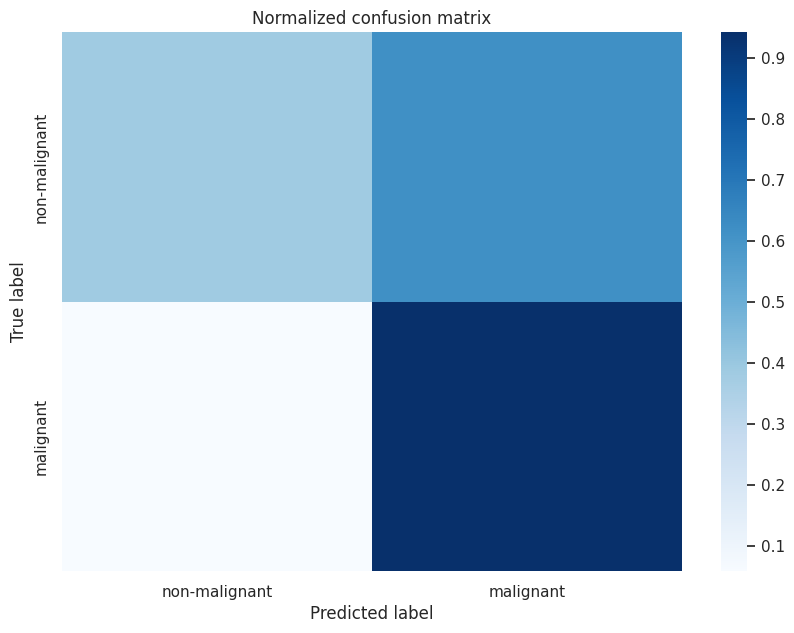

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=False, cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load the saved results
results = torch.load('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_cancer.pt')
labels = results['labels']
preds = results['preds']
labels_cpu = labels.cpu().numpy() if hasattr(labels, 'cpu') else np.array(labels)
preds_cpu = preds.cpu().numpy() if hasattr(preds, 'cpu') else np.array(preds)

# For cancer classification, use the cancer classes
types = ["non-malignant", "malignant"]

plot_confusion_matrix(labels_cpu, preds_cpu, types, normalize=True)

In [28]:
import anndata as ad, scanpy as sc
cell_embs = results['cell_embs']
cell_embs_ad = ad.AnnData(cell_embs.numpy())
cell_embs_ad.obs['cancer_status'] = dataset_sub['cancer_status']
if 'batch' in dataset_sub.features.keys():
    cell_embs_ad.obs['batch'] = dataset_sub['batch']
    cell_embs_ad.obs['batch'] = cell_embs_ad.obs['batch'].astype(str)
cell_embs_ad.obs['predictions'] = [types[i] for i in preds]

# Compute neighbors
sc.pp.neighbors(cell_embs_ad, use_rep='X', n_neighbors=80)

# Compute UMAP
sc.tl.umap(cell_embs_ad)

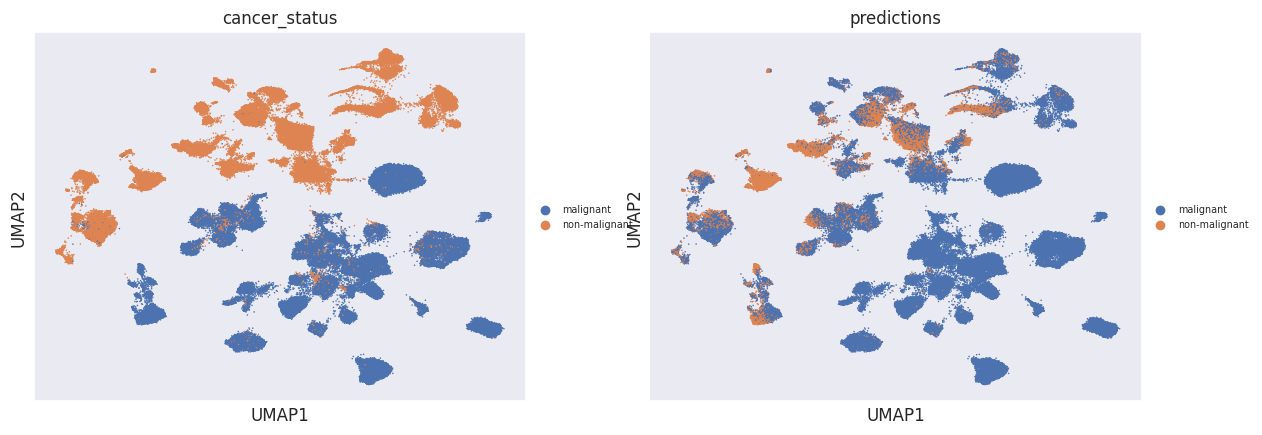

In [29]:
# List of columns you want to color by
color_keys = ['cancer_status', 'predictions', 'batch']

# Only keep those that exist in .obs
existing_keys = [k for k in color_keys if k in cell_embs_ad.obs.columns]

sc.pl.umap(cell_embs_ad, color=existing_keys, legend_fontsize='xx-small', size=5, legend_fontweight='light')

It is evident that the cell embeddings generated directly by LangCell, without any fine-tuning, possess desirable properties: they cluster by cell type and eliminate batch effects. By comparing the left and middle plots, one can intuitively observe that LangCell is capable of reliably annotating cell types in a zero-shot scenario.
